In [115]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt
from pandas.core.common import flatten
import copy
import numpy as np
import random

import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as T

import albumentations as A
from albumentations.pytorch import ToTensorV2
from albumentations.augmentations import ToFloat 
import cv2
import glob
from tqdm import tqdm
import cv2

import splitfolders

In [116]:
train_transforms = A.Compose(
    [
        A.Resize(height=224,width=224),
        #A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.05, rotate_limit=360, p=0.5),
        A.RandomRotate90(),
        #A.RandomCrop(height=224, width=224),
        #A.RGBShift(r_shift_limit=15, g_shift_limit=15, b_shift_limit=15, p=0.5),
        A.HorizontalFlip(p=1),
        A.RandomBrightnessContrast(p=1),
        A.GaussNoise(),
        #A.MultiplicativeNoise(multiplier=[0.5,2], per_channel=True, p=0.2),
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        #A.HueSaturationValue(hue_shift_limit=0.2, sat_shift_limit=0.2, val_shift_limit=0.2, p=0.5),
        #A.RandomBrightnessContrast(brightness_limit=(-0.1,0.1), contrast_limit=(-0.1, 0.1), p=0.5),
        #T.RandomBrightness(p=0.5),
        ToTensorV2(),
        
    ]
)

test_transforms = A.Compose(
    [
        #A.SmallestMaxSize(max_size=224),
        #A.CenterCrop(height=224, width=225),
        A.Resize(height=224,width=224),
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        ToTensorV2(),
       
    ]
)

In [117]:
# Split with a ratio.
# To only split into training and validation set, set a tuple to `ratio`, i.e, `(.8, .2)`.

splitfolders.ratio("data", output="output", ratio=(.7, .1, .2), group_prefix=None, move=False) # default values

# Split val/test with a fixed number of items, e.g. `(100, 100)`, for each set.
# To only split into training and validation set, use a single number to `fixed`, i.e., `10`.
# Set 3 values, e.g. `(300, 100, 100)`, to limit the number of training values.
#splitfolders.fixed("data", output="output", seed=1337, fixed=(100, 100), oversample=False, group_prefix=None, move=False) # default values

Copying files: 1787 files [00:01, 938.24 files/s]


In [118]:
train_data_path = 'output/train'
test_data_path = 'output/test'
valid_data_path = 'output/val' 

train_image_paths = [] #to store image paths in list
classes = [] #to store class values

#1.
# get all the paths from train_data_path and append image paths and class to to respective lists
# eg. train path-> 'images/train/26.Pont_du_Gard/4321ee6695c23c7b.jpg'
# eg. class -> 26.Pont_du_Gard
for data_path in glob.glob(train_data_path + '/*'):
    classes.append(data_path.split('/')[-1]) 
    train_image_paths.append(glob.glob(data_path + '/*'))
    
train_image_paths = list(flatten(train_image_paths))
random.shuffle(train_image_paths)

print('class example: ', classes[0])
print('train_image_path example: ', train_image_paths[0])

#2.
# split train valid from train paths (80,20)
#train_image_paths, valid_image_paths = train_image_paths[:int(0.8*len(train_image_paths))], train_image_paths[int(0.2*len(train_image_paths)):] 

#3.
# create the test_image_paths

test_image_paths = []
for data_path in glob.glob(test_data_path + '/*'):
    test_image_paths.append(glob.glob(data_path + '/*'))

test_image_paths = list(flatten(test_image_paths))
random.shuffle(test_image_paths)

print('test_image_path example: ', test_image_paths[0])

#3.
# create the test_image_paths
valid_image_paths = []
for data_path in glob.glob(valid_data_path + '/*'):
    valid_image_paths.append(glob.glob(data_path + '/*'))

valid_image_paths = list(flatten(valid_image_paths))
random.shuffle(valid_image_paths)

print('valid_image_path example: ', valid_image_paths[0])

print("Train size: {}\nTest size: {}\nValid size: {}\n".format(len(train_image_paths), len(test_image_paths), len(valid_image_paths)))
# print("Train size: {}\nValid size: {}\n".format(len(train_image_paths), len(valid_image_paths)))



class example:  Lepidium draba
train_image_path example:  output/train/Sambucus ebulus/1.jpg
test_image_path example:  output/test/Lotus corniculatus/4.jpg
valid_image_path example:  output/val/Epilobium parviflorum/3.jpg
Train size: 1354
Test size: 662
Valid size: 497



In [119]:
#######################################################
#      Create dictionary for class indexes            #
#######################################################

idx_to_class = {i:j for i, j in enumerate(classes)}
class_to_idx = {value:key for key,value in idx_to_class.items()}

In [120]:
#######################################################
#               Define Dataset Class                  #
#######################################################

class pollenDataset(Dataset):
    def __init__(self, image_paths, transform=False):
        self.image_paths = image_paths
        self.transform = transform
        
    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_filepath = self.image_paths[idx]
        image = cv2.imread(image_filepath)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        
        label = image_filepath.split('/')[-2]
        label = class_to_idx[label]
        if self.transform is not None:
            image = self.transform(image=image)["image"]
        
        return image, label
    
#######################################################
#                  Create Dataset                     #
#######################################################

train_dataset = pollenDataset(train_image_paths,train_transforms)
test_dataset = pollenDataset(test_image_paths,test_transforms)
valid_dataset = pollenDataset(valid_image_paths,test_transforms) #test transforms are applied

In [121]:
print('The shape of tensor for 50th image in train dataset: ',train_dataset[2][0].shape)
print('The label for 50th image in train dataset: ',train_dataset[2][1])

The shape of tensor for 50th image in train dataset:  torch.Size([3, 224, 224])
The label for 50th image in train dataset:  181


Copying files: 1309 files [14:35:21, 40.12s/ files]


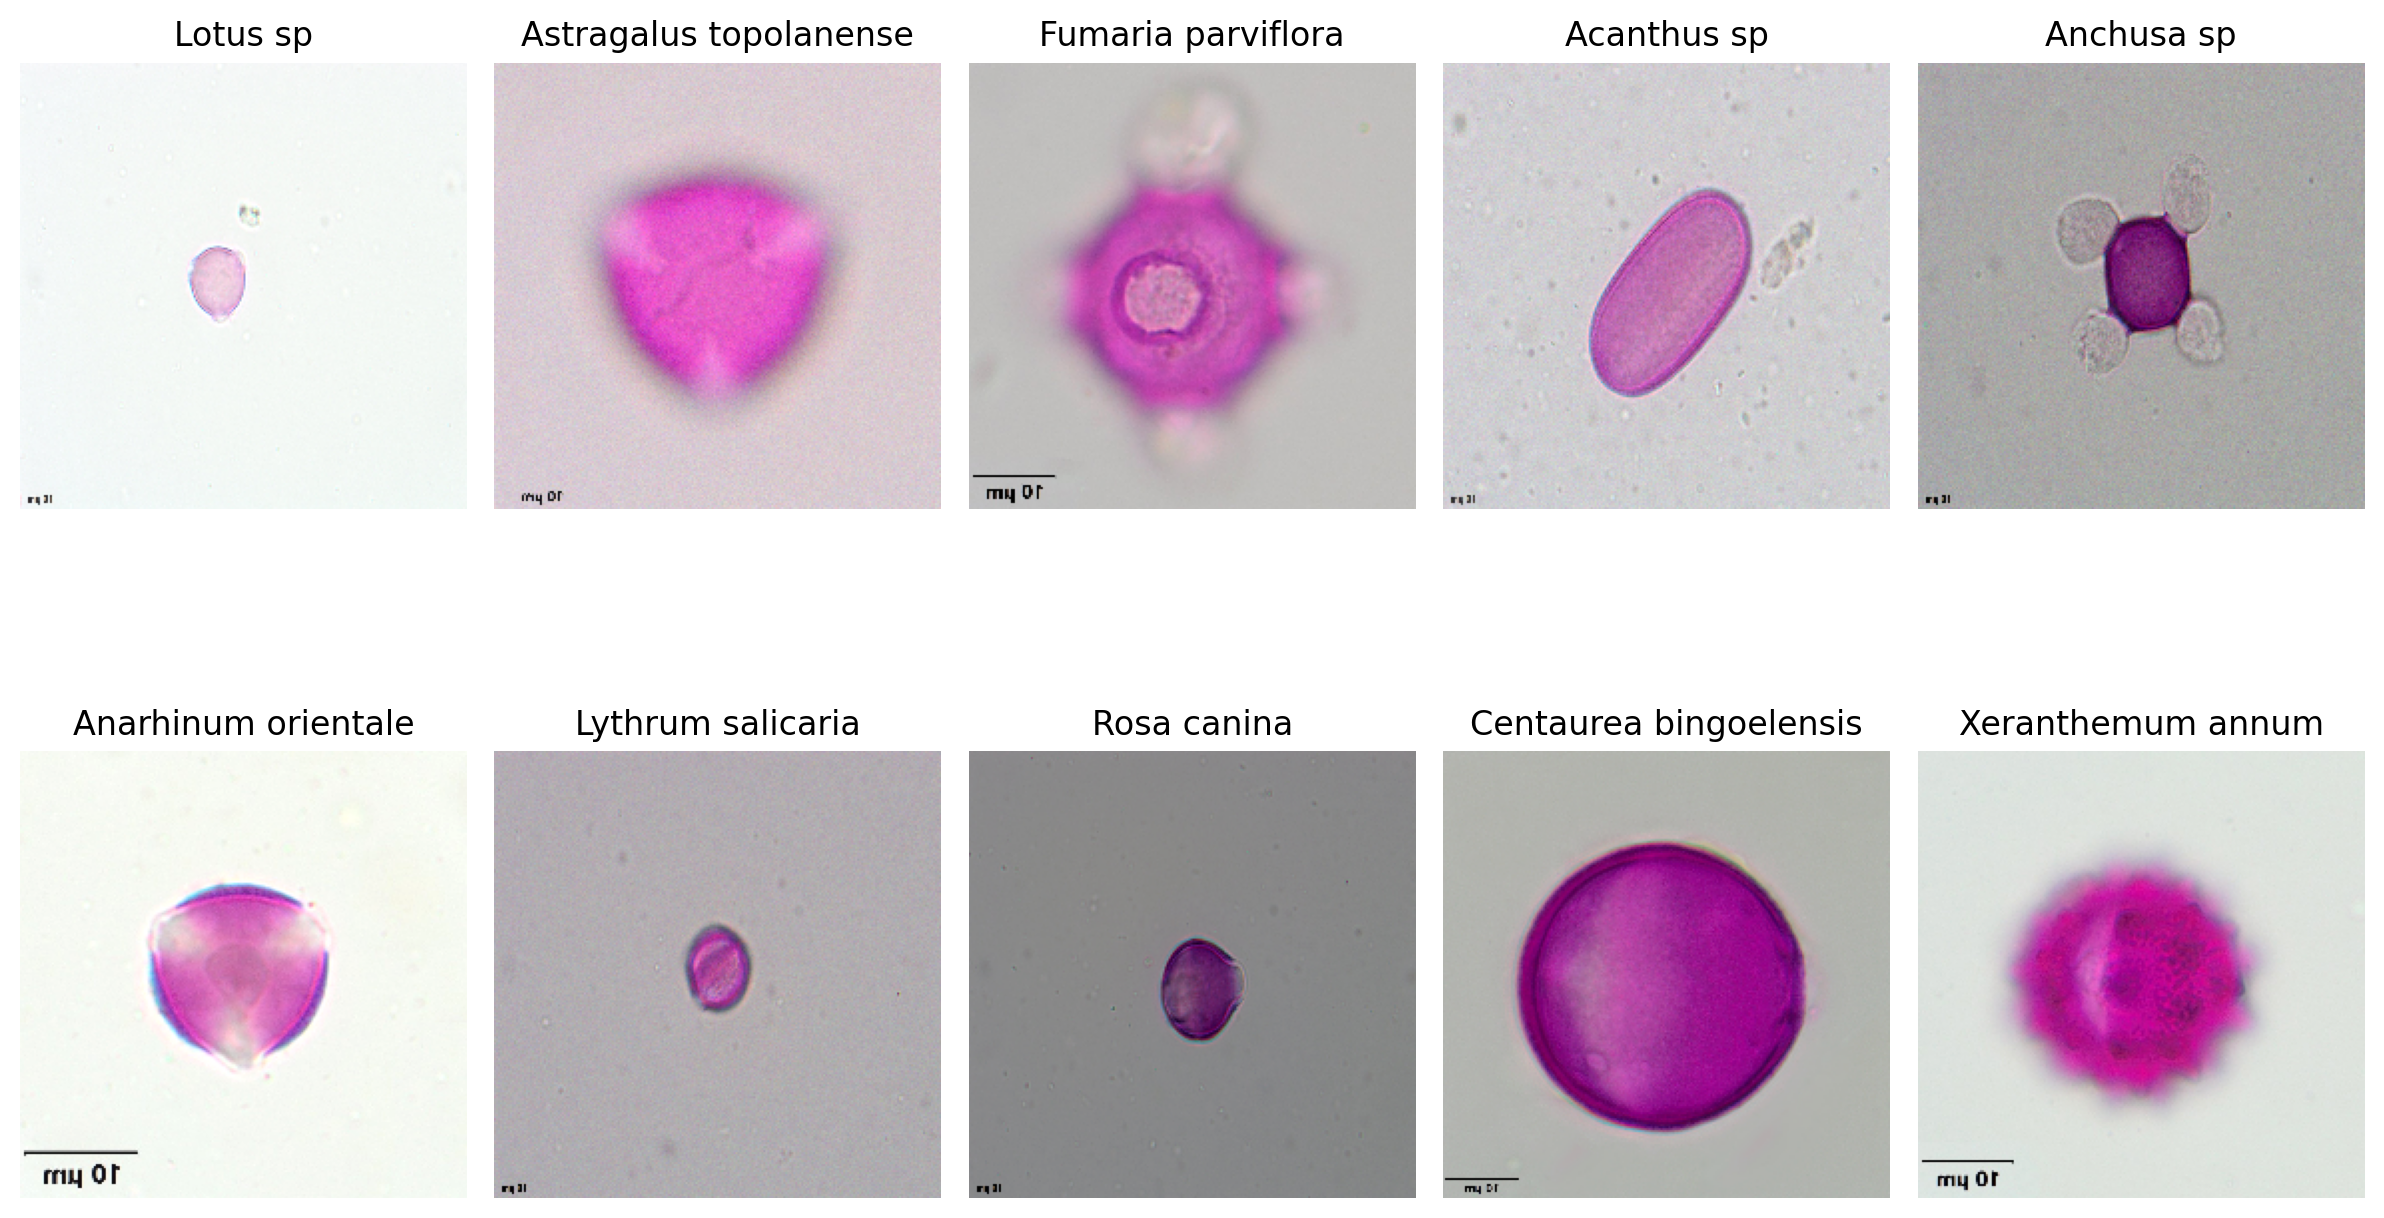

In [122]:
def visualize_augmentations(dataset, idx=0, samples=10, cols=5, random_img = False):
    
    dataset = copy.deepcopy(dataset)
    #we remove the normalize and tensor conversion from our augmentation pipeline
    dataset.transform = A.Compose([t for t in dataset.transform if not isinstance(t, (A.Normalize, ToTensorV2))])
    rows = samples // cols
    
        
    figure, ax = plt.subplots(nrows=rows, ncols=cols, figsize=(12, 8))
    for i in range(samples):
          idx = np.random.randint(1,len(train_image_paths))
          image, lab = dataset[idx]
          ax.ravel()[i].imshow(image)
          ax.ravel()[i].set_axis_off()
          ax.ravel()[i].set_title(idx_to_class[lab])
    plt.tight_layout(pad=1)
    plt.show()    

visualize_augmentations(train_dataset,np.random.randint(1,len(train_image_paths)), random_img = True)

In [123]:
#######################################################
#                  Define Dataloaders
#######################################################

train_loader = DataLoader(
    train_dataset, batch_size=64, shuffle=True
)

valid_loader = DataLoader(
    valid_dataset, batch_size=64, shuffle=True
)


test_loader = DataLoader(
    test_dataset, batch_size=64, shuffle=False
)

In [124]:
loaders = {"train": train_loader, "val": valid_loader}

In [125]:
dataset_length = {"train" : len(train_dataset) , "val" : len(valid_dataset)}

In [126]:
next(iter(train_loader))[1].shape


torch.Size([64])

In [127]:
import numpy as np

from tqdm import tqdm, trange

import torch
import torch.nn as nn
from torch.optim import Adam
from torch.nn import CrossEntropyLoss
from torch.utils.data import DataLoader

from torchvision.transforms import ToTensor
from torchvision.datasets.mnist import MNIST

np.random.seed(0)
torch.manual_seed(0)

In [128]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os

In [129]:
import torch
import torchvision
from torchvision import datasets
from torchvision import transforms as T # for simplifying the transforms
from torch import nn, optim
from torch.nn import functional as F
from torch.utils.data import DataLoader, sampler, random_split
from torchvision import models

In [130]:
import timm
from timm.loss import LabelSmoothingCrossEntropy # This is better than normal nn.CrossEntropyLoss

In [131]:
import sys
from tqdm import tqdm
import time
import copy

In [132]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [133]:
model = torch.hub.load('facebookresearch/deit:main', 'deit_base_patch16_224', pretrained=True)

Using cache found in /Users/nofil/.cache/torch/hub/facebookresearch_deit_main


In [134]:
for param in model.parameters(): #freeze model
    param.requires_grad = False

n_inputs = model.head.in_features
model.head = nn.Sequential(
    nn.Linear(n_inputs, 512),
    nn.ReLU(),
    nn.Dropout(0.3),
    nn.Linear(512, len(classes))
)
model = model.to(device)
print(model.head)

Sequential(
  (0): Linear(in_features=768, out_features=512, bias=True)
  (1): ReLU()
  (2): Dropout(p=0.3, inplace=False)
  (3): Linear(in_features=512, out_features=274, bias=True)
)


In [135]:
criterion = LabelSmoothingCrossEntropy()
criterion = criterion.to(device)
optimizer = optim.Adam(model.head.parameters(), lr=0.001)

In [136]:
exp_lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=1)

In [137]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=100):
    since = time.time()
    
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    validation_values = []
    train_values = []

    train_losses = []
    val_losses = []
    
    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print("-"*10)
        
        for phase in ['train', 'val']: # We do training and validation phase per epoch
            if phase == 'train':
                model.train() # model to training mode
            else:
                model.eval() # model to evaluate
            
            running_loss = 0.0
            running_corrects = 0.0
            
            for inputs, labels in tqdm(loaders[phase]):
                inputs = inputs.to(device)
                labels = labels.to(device)
                
                optimizer.zero_grad()
                
                with torch.set_grad_enabled(phase == 'train'): # no autograd makes validation go faster
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1) # used for accuracy
                    loss = criterion(outputs, labels)
                    
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                
            if phase == 'train':
                scheduler.step() # step at end of epoch
            
            epoch_loss = running_loss / dataset_length[phase]
            epoch_acc =  running_corrects.double() / dataset_length[phase]
            
            print("{} Loss: {:.4f} Acc: {:.4f}".format(phase, epoch_loss, epoch_acc))
            
            #adding acc  and loss data to list
            if phase == 'train':
                train_values.append(epoch_acc)
                train_losses.append(loss.item())
            elif phase == 'val':
                validation_values.append(epoch_acc)
                val_losses.append(loss.item())
            
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict()) # keep the best validation accuracy model
        print()
    time_elapsed = time.time() - since # slight error
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print("Best Val Acc: {:.4f}".format(best_acc))
    
    model.load_state_dict(best_model_wts)

    # Plotting accuracies
    plt.figure(figsize=(10, 6))
    plt.plot(train_values, label='train_acc')
    plt.plot(validation_values, label='val_acc')
    plt.title('Training and validation accuracies')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

    # Plotting losses
    plt.figure(figsize=(10, 6))
    plt.plot(train_losses, label='train loss')
    plt.plot(val_losses, label='val loss')
    plt.legend()
    plt.show()
    
    return model

Epoch 0/99
----------


100%|██████████| 22/22 [02:21<00:00,  6.42s/it]


train Loss: 5.2948 Acc: 0.0473


100%|██████████| 8/8 [00:52<00:00,  6.59s/it]


val Loss: 4.6821 Acc: 0.1489

Epoch 1/99
----------


100%|██████████| 22/22 [02:28<00:00,  6.76s/it]


train Loss: 4.5343 Acc: 0.1352


100%|██████████| 8/8 [00:51<00:00,  6.45s/it]


val Loss: 4.2239 Acc: 0.1469

Epoch 2/99
----------


100%|██████████| 22/22 [02:21<00:00,  6.44s/it]


train Loss: 4.0495 Acc: 0.1979


100%|██████████| 8/8 [00:50<00:00,  6.26s/it]


val Loss: 3.8202 Acc: 0.2495

Epoch 3/99
----------


100%|██████████| 22/22 [02:35<00:00,  7.05s/it]


train Loss: 3.5748 Acc: 0.3006


100%|██████████| 8/8 [00:56<00:00,  7.06s/it]


val Loss: 3.5162 Acc: 0.3380

Epoch 4/99
----------


100%|██████████| 22/22 [02:28<00:00,  6.73s/it]


train Loss: 3.2399 Acc: 0.3774


100%|██████████| 8/8 [00:49<00:00,  6.19s/it]


val Loss: 3.2394 Acc: 0.4205

Epoch 5/99
----------


100%|██████████| 22/22 [02:24<00:00,  6.56s/it]


train Loss: 2.9470 Acc: 0.4520


100%|██████████| 8/8 [00:51<00:00,  6.47s/it]


val Loss: 3.0672 Acc: 0.4346

Epoch 6/99
----------


100%|██████████| 22/22 [02:22<00:00,  6.46s/it]


train Loss: 2.6958 Acc: 0.5207


100%|██████████| 8/8 [00:52<00:00,  6.50s/it]


val Loss: 2.9278 Acc: 0.5030

Epoch 7/99
----------


100%|██████████| 22/22 [02:25<00:00,  6.63s/it]


train Loss: 2.5001 Acc: 0.5901


100%|██████████| 8/8 [00:51<00:00,  6.41s/it]


val Loss: 2.7667 Acc: 0.5392

Epoch 8/99
----------


100%|██████████| 22/22 [02:24<00:00,  6.56s/it]


train Loss: 2.3273 Acc: 0.6610


100%|██████████| 8/8 [00:53<00:00,  6.70s/it]


val Loss: 2.7360 Acc: 0.5332

Epoch 9/99
----------


100%|██████████| 22/22 [02:29<00:00,  6.81s/it]


train Loss: 2.2160 Acc: 0.6699


100%|██████████| 8/8 [00:50<00:00,  6.33s/it]


val Loss: 2.6442 Acc: 0.5775

Epoch 10/99
----------


100%|██████████| 22/22 [02:20<00:00,  6.40s/it]


train Loss: 2.1098 Acc: 0.7112


100%|██████████| 8/8 [00:50<00:00,  6.36s/it]


val Loss: 2.5831 Acc: 0.5795

Epoch 11/99
----------


100%|██████████| 22/22 [02:20<00:00,  6.38s/it]


train Loss: 2.0176 Acc: 0.7504


100%|██████████| 8/8 [00:52<00:00,  6.57s/it]


val Loss: 2.5395 Acc: 0.6076

Epoch 12/99
----------


100%|██████████| 22/22 [02:33<00:00,  6.99s/it]


train Loss: 1.9541 Acc: 0.7674


100%|██████████| 8/8 [00:52<00:00,  6.54s/it]


val Loss: 2.4906 Acc: 0.5936

Epoch 13/99
----------


100%|██████████| 22/22 [02:24<00:00,  6.56s/it]


train Loss: 1.8670 Acc: 0.8109


100%|██████████| 8/8 [00:51<00:00,  6.42s/it]


val Loss: 2.4542 Acc: 0.5976

Epoch 14/99
----------


100%|██████████| 22/22 [02:28<00:00,  6.74s/it]


train Loss: 1.7849 Acc: 0.8383


100%|██████████| 8/8 [00:51<00:00,  6.49s/it]


val Loss: 2.4600 Acc: 0.5895

Epoch 15/99
----------


100%|██████████| 22/22 [02:23<00:00,  6.53s/it]


train Loss: 1.7368 Acc: 0.8383


100%|██████████| 8/8 [00:52<00:00,  6.51s/it]


val Loss: 2.3878 Acc: 0.6217

Epoch 16/99
----------


100%|██████████| 22/22 [02:24<00:00,  6.55s/it]


train Loss: 1.7130 Acc: 0.8331


100%|██████████| 8/8 [00:52<00:00,  6.55s/it]


val Loss: 2.3768 Acc: 0.6157

Epoch 17/99
----------


100%|██████████| 22/22 [02:21<00:00,  6.42s/it]


train Loss: 1.6779 Acc: 0.8708


100%|██████████| 8/8 [00:52<00:00,  6.51s/it]


val Loss: 2.3681 Acc: 0.6338

Epoch 18/99
----------


100%|██████████| 22/22 [02:26<00:00,  6.65s/it]


train Loss: 1.6562 Acc: 0.8737


100%|██████████| 8/8 [00:51<00:00,  6.38s/it]


val Loss: 2.3260 Acc: 0.6298

Epoch 19/99
----------


100%|██████████| 22/22 [02:21<00:00,  6.45s/it]


train Loss: 1.5800 Acc: 0.8929


100%|██████████| 8/8 [00:51<00:00,  6.46s/it]


val Loss: 2.3111 Acc: 0.6479

Epoch 20/99
----------


100%|██████████| 22/22 [02:26<00:00,  6.67s/it]


train Loss: 1.5738 Acc: 0.8951


100%|██████████| 8/8 [00:51<00:00,  6.49s/it]


val Loss: 2.2989 Acc: 0.6479

Epoch 21/99
----------


100%|██████████| 22/22 [02:21<00:00,  6.45s/it]


train Loss: 1.5704 Acc: 0.8885


100%|██████████| 8/8 [00:51<00:00,  6.40s/it]


val Loss: 2.2878 Acc: 0.6439

Epoch 22/99
----------


100%|██████████| 22/22 [02:21<00:00,  6.45s/it]


train Loss: 1.5276 Acc: 0.9099


100%|██████████| 8/8 [00:51<00:00,  6.39s/it]


val Loss: 2.2770 Acc: 0.6358

Epoch 23/99
----------


100%|██████████| 22/22 [02:21<00:00,  6.45s/it]


train Loss: 1.4880 Acc: 0.9180


100%|██████████| 8/8 [00:51<00:00,  6.39s/it]


val Loss: 2.2521 Acc: 0.6559

Epoch 24/99
----------


100%|██████████| 22/22 [02:23<00:00,  6.51s/it]


train Loss: 1.4690 Acc: 0.9165


100%|██████████| 8/8 [00:52<00:00,  6.51s/it]


val Loss: 2.2438 Acc: 0.6459

Epoch 25/99
----------


100%|██████████| 22/22 [02:25<00:00,  6.61s/it]


train Loss: 1.4741 Acc: 0.9136


100%|██████████| 8/8 [00:53<00:00,  6.63s/it]


val Loss: 2.2680 Acc: 0.6479

Epoch 26/99
----------


100%|██████████| 22/22 [02:24<00:00,  6.57s/it]


train Loss: 1.4572 Acc: 0.9298


100%|██████████| 8/8 [00:52<00:00,  6.52s/it]


val Loss: 2.2420 Acc: 0.6539

Epoch 27/99
----------


100%|██████████| 22/22 [02:25<00:00,  6.60s/it]


train Loss: 1.4423 Acc: 0.9239


100%|██████████| 8/8 [00:52<00:00,  6.57s/it]


val Loss: 2.2697 Acc: 0.6439

Epoch 28/99
----------


100%|██████████| 22/22 [02:24<00:00,  6.59s/it]


train Loss: 1.4272 Acc: 0.9394


100%|██████████| 8/8 [00:52<00:00,  6.54s/it]


val Loss: 2.2666 Acc: 0.6258

Epoch 29/99
----------


100%|██████████| 22/22 [02:25<00:00,  6.61s/it]


train Loss: 1.3950 Acc: 0.9446


100%|██████████| 8/8 [00:52<00:00,  6.53s/it]


val Loss: 2.2085 Acc: 0.6600

Epoch 30/99
----------


100%|██████████| 22/22 [02:24<00:00,  6.55s/it]


train Loss: 1.3783 Acc: 0.9394


100%|██████████| 8/8 [00:52<00:00,  6.51s/it]


val Loss: 2.2174 Acc: 0.6579

Epoch 31/99
----------


100%|██████████| 22/22 [02:26<00:00,  6.64s/it]


train Loss: 1.3814 Acc: 0.9476


100%|██████████| 8/8 [00:53<00:00,  6.65s/it]


val Loss: 2.2357 Acc: 0.6439

Epoch 32/99
----------


100%|██████████| 22/22 [02:24<00:00,  6.58s/it]


train Loss: 1.3679 Acc: 0.9483


100%|██████████| 8/8 [00:52<00:00,  6.51s/it]


val Loss: 2.2048 Acc: 0.6579

Epoch 33/99
----------


100%|██████████| 22/22 [02:24<00:00,  6.56s/it]


train Loss: 1.3621 Acc: 0.9439


100%|██████████| 8/8 [00:54<00:00,  6.82s/it]


val Loss: 2.2163 Acc: 0.6559

Epoch 34/99
----------


100%|██████████| 22/22 [02:27<00:00,  6.71s/it]


train Loss: 1.3446 Acc: 0.9490


100%|██████████| 8/8 [00:52<00:00,  6.55s/it]


val Loss: 2.1981 Acc: 0.6620

Epoch 35/99
----------


100%|██████████| 22/22 [02:25<00:00,  6.61s/it]


train Loss: 1.3478 Acc: 0.9476


100%|██████████| 8/8 [00:52<00:00,  6.53s/it]


val Loss: 2.1678 Acc: 0.6660

Epoch 36/99
----------


100%|██████████| 22/22 [02:26<00:00,  6.66s/it]


train Loss: 1.3278 Acc: 0.9505


100%|██████████| 8/8 [00:52<00:00,  6.58s/it]


val Loss: 2.2089 Acc: 0.6559

Epoch 37/99
----------


100%|██████████| 22/22 [02:29<00:00,  6.80s/it]


train Loss: 1.3321 Acc: 0.9549


100%|██████████| 8/8 [00:54<00:00,  6.85s/it]


val Loss: 2.1673 Acc: 0.6720

Epoch 38/99
----------


100%|██████████| 22/22 [02:23<00:00,  6.51s/it]


train Loss: 1.2993 Acc: 0.9616


100%|██████████| 8/8 [00:52<00:00,  6.60s/it]


val Loss: 2.1650 Acc: 0.6720

Epoch 39/99
----------


100%|██████████| 22/22 [02:23<00:00,  6.52s/it]


train Loss: 1.2885 Acc: 0.9660


100%|██████████| 8/8 [00:50<00:00,  6.37s/it]


val Loss: 2.1721 Acc: 0.6700

Epoch 40/99
----------


100%|██████████| 22/22 [02:25<00:00,  6.60s/it]


train Loss: 1.2852 Acc: 0.9690


100%|██████████| 8/8 [00:52<00:00,  6.58s/it]


val Loss: 2.1656 Acc: 0.6559

Epoch 41/99
----------


100%|██████████| 22/22 [02:22<00:00,  6.49s/it]


train Loss: 1.2893 Acc: 0.9616


100%|██████████| 8/8 [00:50<00:00,  6.37s/it]


val Loss: 2.1547 Acc: 0.6901

Epoch 42/99
----------


100%|██████████| 22/22 [02:23<00:00,  6.51s/it]


train Loss: 1.2745 Acc: 0.9682


100%|██████████| 8/8 [00:51<00:00,  6.39s/it]


val Loss: 2.1593 Acc: 0.6579

Epoch 43/99
----------


100%|██████████| 22/22 [02:24<00:00,  6.55s/it]


train Loss: 1.2616 Acc: 0.9719


100%|██████████| 8/8 [00:51<00:00,  6.45s/it]


val Loss: 2.1420 Acc: 0.6781

Epoch 44/99
----------


100%|██████████| 22/22 [02:23<00:00,  6.54s/it]


train Loss: 1.2843 Acc: 0.9609


100%|██████████| 8/8 [00:50<00:00,  6.27s/it]


val Loss: 2.1479 Acc: 0.6579

Epoch 45/99
----------


100%|██████████| 22/22 [02:38<00:00,  7.21s/it]


train Loss: 1.2627 Acc: 0.9668


100%|██████████| 8/8 [00:56<00:00,  7.10s/it]


val Loss: 2.1530 Acc: 0.6761

Epoch 46/99
----------


100%|██████████| 22/22 [02:25<00:00,  6.63s/it]


train Loss: 1.2467 Acc: 0.9756


100%|██████████| 8/8 [00:51<00:00,  6.46s/it]


val Loss: 2.1282 Acc: 0.6841

Epoch 47/99
----------


100%|██████████| 22/22 [02:26<00:00,  6.64s/it]


train Loss: 1.2504 Acc: 0.9653


100%|██████████| 8/8 [00:51<00:00,  6.50s/it]


val Loss: 2.1523 Acc: 0.6740

Epoch 48/99
----------


100%|██████████| 22/22 [02:25<00:00,  6.62s/it]


train Loss: 1.2278 Acc: 0.9742


100%|██████████| 8/8 [00:52<00:00,  6.58s/it]


val Loss: 2.1468 Acc: 0.6740

Epoch 49/99
----------


100%|██████████| 22/22 [02:24<00:00,  6.56s/it]


train Loss: 1.2164 Acc: 0.9815


100%|██████████| 8/8 [00:52<00:00,  6.53s/it]


val Loss: 2.1282 Acc: 0.6881

Epoch 50/99
----------


100%|██████████| 22/22 [02:25<00:00,  6.60s/it]


train Loss: 1.2430 Acc: 0.9712


100%|██████████| 8/8 [00:52<00:00,  6.60s/it]


val Loss: 2.1444 Acc: 0.6781

Epoch 51/99
----------


100%|██████████| 22/22 [02:24<00:00,  6.58s/it]


train Loss: 1.2334 Acc: 0.9749


100%|██████████| 8/8 [00:51<00:00,  6.48s/it]


val Loss: 2.1097 Acc: 0.6861

Epoch 52/99
----------


100%|██████████| 22/22 [02:25<00:00,  6.60s/it]


train Loss: 1.2293 Acc: 0.9719


100%|██████████| 8/8 [00:51<00:00,  6.47s/it]


val Loss: 2.1342 Acc: 0.6841

Epoch 53/99
----------


100%|██████████| 22/22 [02:23<00:00,  6.53s/it]


train Loss: 1.2391 Acc: 0.9719


100%|██████████| 8/8 [00:51<00:00,  6.49s/it]


val Loss: 2.1254 Acc: 0.6680

Epoch 54/99
----------


100%|██████████| 22/22 [02:24<00:00,  6.55s/it]


train Loss: 1.2236 Acc: 0.9727


100%|██████████| 8/8 [00:52<00:00,  6.60s/it]


val Loss: 2.1075 Acc: 0.6740

Epoch 55/99
----------


100%|██████████| 22/22 [02:24<00:00,  6.56s/it]


train Loss: 1.2112 Acc: 0.9771


100%|██████████| 8/8 [00:51<00:00,  6.48s/it]


val Loss: 2.1372 Acc: 0.6640

Epoch 56/99
----------


100%|██████████| 22/22 [02:22<00:00,  6.49s/it]


train Loss: 1.2313 Acc: 0.9749


100%|██████████| 8/8 [00:51<00:00,  6.42s/it]


val Loss: 2.1162 Acc: 0.6700

Epoch 57/99
----------


100%|██████████| 22/22 [02:26<00:00,  6.67s/it]


train Loss: 1.2096 Acc: 0.9823


100%|██████████| 8/8 [00:52<00:00,  6.58s/it]


val Loss: 2.1035 Acc: 0.6740

Epoch 58/99
----------


100%|██████████| 22/22 [02:23<00:00,  6.51s/it]


train Loss: 1.2036 Acc: 0.9808


100%|██████████| 8/8 [00:51<00:00,  6.39s/it]


val Loss: 2.1018 Acc: 0.6821

Epoch 59/99
----------


100%|██████████| 22/22 [02:23<00:00,  6.52s/it]


train Loss: 1.2004 Acc: 0.9786


100%|██████████| 8/8 [00:51<00:00,  6.50s/it]


val Loss: 2.1033 Acc: 0.6901

Epoch 60/99
----------


100%|██████████| 22/22 [02:30<00:00,  6.85s/it]


train Loss: 1.2093 Acc: 0.9697


100%|██████████| 8/8 [00:54<00:00,  6.84s/it]


val Loss: 2.1087 Acc: 0.6901

Epoch 61/99
----------


100%|██████████| 22/22 [02:23<00:00,  6.54s/it]


train Loss: 1.2068 Acc: 0.9764


100%|██████████| 8/8 [00:50<00:00,  6.34s/it]


val Loss: 2.0849 Acc: 0.6881

Epoch 62/99
----------


100%|██████████| 22/22 [02:21<00:00,  6.45s/it]


train Loss: 1.2029 Acc: 0.9793


100%|██████████| 8/8 [00:50<00:00,  6.37s/it]


val Loss: 2.1034 Acc: 0.6861

Epoch 63/99
----------


100%|██████████| 22/22 [02:22<00:00,  6.47s/it]


train Loss: 1.1927 Acc: 0.9786


100%|██████████| 8/8 [00:51<00:00,  6.41s/it]


val Loss: 2.1255 Acc: 0.6680

Epoch 64/99
----------


100%|██████████| 22/22 [02:22<00:00,  6.49s/it]


train Loss: 1.1808 Acc: 0.9786


100%|██████████| 8/8 [00:52<00:00,  6.52s/it]


val Loss: 2.1433 Acc: 0.6761

Epoch 65/99
----------


100%|██████████| 22/22 [02:37<00:00,  7.16s/it]


train Loss: 1.1801 Acc: 0.9801


100%|██████████| 8/8 [00:51<00:00,  6.48s/it]


val Loss: 2.1343 Acc: 0.6620

Epoch 66/99
----------


100%|██████████| 22/22 [02:25<00:00,  6.61s/it]


train Loss: 1.1789 Acc: 0.9845


100%|██████████| 8/8 [00:52<00:00,  6.55s/it]


val Loss: 2.1406 Acc: 0.6720

Epoch 67/99
----------


100%|██████████| 22/22 [02:23<00:00,  6.50s/it]


train Loss: 1.1789 Acc: 0.9815


100%|██████████| 8/8 [00:51<00:00,  6.45s/it]


val Loss: 2.1070 Acc: 0.6781

Epoch 68/99
----------


100%|██████████| 22/22 [02:23<00:00,  6.51s/it]


train Loss: 1.1747 Acc: 0.9860


100%|██████████| 8/8 [00:51<00:00,  6.46s/it]


val Loss: 2.1319 Acc: 0.6821

Epoch 69/99
----------


100%|██████████| 22/22 [02:27<00:00,  6.72s/it]


train Loss: 1.1757 Acc: 0.9838


100%|██████████| 8/8 [00:57<00:00,  7.16s/it]


val Loss: 2.1128 Acc: 0.6720

Epoch 70/99
----------


100%|██████████| 22/22 [02:47<00:00,  7.60s/it]


train Loss: 1.1647 Acc: 0.9882


100%|██████████| 8/8 [00:55<00:00,  6.96s/it]


val Loss: 2.1407 Acc: 0.6680

Epoch 71/99
----------


100%|██████████| 22/22 [02:34<00:00,  7.02s/it]


train Loss: 1.1678 Acc: 0.9860


100%|██████████| 8/8 [00:53<00:00,  6.63s/it]


val Loss: 2.1034 Acc: 0.6761

Epoch 72/99
----------


100%|██████████| 22/22 [02:29<00:00,  6.81s/it]


train Loss: 1.1604 Acc: 0.9838


100%|██████████| 8/8 [00:53<00:00,  6.71s/it]


val Loss: 2.0885 Acc: 0.6841

Epoch 73/99
----------


100%|██████████| 22/22 [02:39<00:00,  7.23s/it]


train Loss: 1.1540 Acc: 0.9874


100%|██████████| 8/8 [00:50<00:00,  6.26s/it]


val Loss: 2.1079 Acc: 0.6821

Epoch 74/99
----------


100%|██████████| 22/22 [02:19<00:00,  6.34s/it]


train Loss: 1.1541 Acc: 0.9882


100%|██████████| 8/8 [00:49<00:00,  6.25s/it]


val Loss: 2.1321 Acc: 0.6781

Epoch 75/99
----------


100%|██████████| 22/22 [02:27<00:00,  6.69s/it]


train Loss: 1.1592 Acc: 0.9823


100%|██████████| 8/8 [00:50<00:00,  6.31s/it]


val Loss: 2.1429 Acc: 0.6761

Epoch 76/99
----------


100%|██████████| 22/22 [02:22<00:00,  6.49s/it]


train Loss: 1.1598 Acc: 0.9830


100%|██████████| 8/8 [00:52<00:00,  6.62s/it]


val Loss: 2.1107 Acc: 0.6700

Epoch 77/99
----------


100%|██████████| 22/22 [02:37<00:00,  7.16s/it]


train Loss: 1.1560 Acc: 0.9860


100%|██████████| 8/8 [00:55<00:00,  7.00s/it]


val Loss: 2.1227 Acc: 0.6781

Epoch 78/99
----------


100%|██████████| 22/22 [02:24<00:00,  6.59s/it]


train Loss: 1.1483 Acc: 0.9867


100%|██████████| 8/8 [00:50<00:00,  6.26s/it]


val Loss: 2.0901 Acc: 0.6861

Epoch 79/99
----------


100%|██████████| 22/22 [02:32<00:00,  6.92s/it]


train Loss: 1.1666 Acc: 0.9852


100%|██████████| 8/8 [00:54<00:00,  6.79s/it]


val Loss: 2.1176 Acc: 0.6881

Epoch 80/99
----------


100%|██████████| 22/22 [02:29<00:00,  6.80s/it]


train Loss: 1.1521 Acc: 0.9874


100%|██████████| 8/8 [00:49<00:00,  6.19s/it]


val Loss: 2.0940 Acc: 0.6841

Epoch 81/99
----------


100%|██████████| 22/22 [02:27<00:00,  6.68s/it]


train Loss: 1.1486 Acc: 0.9889


100%|██████████| 8/8 [00:50<00:00,  6.30s/it]


val Loss: 2.1003 Acc: 0.6841

Epoch 82/99
----------


100%|██████████| 22/22 [02:17<00:00,  6.24s/it]


train Loss: 1.1316 Acc: 0.9911


100%|██████████| 8/8 [00:49<00:00,  6.16s/it]


val Loss: 2.1060 Acc: 0.6700

Epoch 83/99
----------


100%|██████████| 22/22 [02:15<00:00,  6.17s/it]


train Loss: 1.1400 Acc: 0.9904


100%|██████████| 8/8 [00:48<00:00,  6.04s/it]


val Loss: 2.0920 Acc: 0.6901

Epoch 84/99
----------


100%|██████████| 22/22 [02:16<00:00,  6.21s/it]


train Loss: 1.1331 Acc: 0.9897


100%|██████████| 8/8 [00:49<00:00,  6.14s/it]


val Loss: 2.0746 Acc: 0.6781

Epoch 85/99
----------


100%|██████████| 22/22 [02:14<00:00,  6.14s/it]


train Loss: 1.1306 Acc: 0.9889


100%|██████████| 8/8 [00:48<00:00,  6.02s/it]


val Loss: 2.0923 Acc: 0.6801

Epoch 86/99
----------


100%|██████████| 22/22 [02:14<00:00,  6.13s/it]


train Loss: 1.1329 Acc: 0.9882


100%|██████████| 8/8 [00:48<00:00,  6.03s/it]


val Loss: 2.0927 Acc: 0.6720

Epoch 87/99
----------


100%|██████████| 22/22 [02:14<00:00,  6.11s/it]


train Loss: 1.1367 Acc: 0.9867


100%|██████████| 8/8 [00:48<00:00,  6.03s/it]


val Loss: 2.1006 Acc: 0.6761

Epoch 88/99
----------


100%|██████████| 22/22 [02:12<00:00,  6.04s/it]


train Loss: 1.1277 Acc: 0.9911


100%|██████████| 8/8 [00:47<00:00,  5.99s/it]


val Loss: 2.0863 Acc: 0.6801

Epoch 89/99
----------


100%|██████████| 22/22 [02:12<00:00,  6.03s/it]


train Loss: 1.1288 Acc: 0.9897


100%|██████████| 8/8 [00:47<00:00,  5.98s/it]


val Loss: 2.0778 Acc: 0.6841

Epoch 90/99
----------


100%|██████████| 22/22 [02:13<00:00,  6.08s/it]


train Loss: 1.1296 Acc: 0.9845


100%|██████████| 8/8 [00:48<00:00,  6.02s/it]


val Loss: 2.1013 Acc: 0.6821

Epoch 91/99
----------


100%|██████████| 22/22 [02:24<00:00,  6.59s/it]


train Loss: 1.1300 Acc: 0.9867


100%|██████████| 8/8 [00:52<00:00,  6.60s/it]


val Loss: 2.0848 Acc: 0.6801

Epoch 92/99
----------


100%|██████████| 22/22 [02:21<00:00,  6.45s/it]


train Loss: 1.1190 Acc: 0.9904


100%|██████████| 8/8 [00:52<00:00,  6.54s/it]


val Loss: 2.1205 Acc: 0.7022

Epoch 93/99
----------


100%|██████████| 22/22 [02:22<00:00,  6.46s/it]


train Loss: 1.1180 Acc: 0.9911


100%|██████████| 8/8 [00:50<00:00,  6.33s/it]


val Loss: 2.1009 Acc: 0.6861

Epoch 94/99
----------


100%|██████████| 22/22 [02:28<00:00,  6.73s/it]


train Loss: 1.1247 Acc: 0.9860


100%|██████████| 8/8 [00:55<00:00,  6.99s/it]


val Loss: 2.1009 Acc: 0.6720

Epoch 95/99
----------


100%|██████████| 22/22 [02:26<00:00,  6.67s/it]


train Loss: 1.1206 Acc: 0.9911


100%|██████████| 8/8 [00:51<00:00,  6.38s/it]


val Loss: 2.0868 Acc: 0.6901

Epoch 96/99
----------


100%|██████████| 22/22 [02:23<00:00,  6.52s/it]


train Loss: 1.1133 Acc: 0.9919


100%|██████████| 8/8 [00:51<00:00,  6.46s/it]


val Loss: 2.0893 Acc: 0.6841

Epoch 97/99
----------


100%|██████████| 22/22 [02:21<00:00,  6.45s/it]


train Loss: 1.1225 Acc: 0.9882


100%|██████████| 8/8 [00:51<00:00,  6.47s/it]


val Loss: 2.1147 Acc: 0.6881

Epoch 98/99
----------


100%|██████████| 22/22 [02:19<00:00,  6.36s/it]


train Loss: 1.1105 Acc: 0.9904


100%|██████████| 8/8 [00:50<00:00,  6.32s/it]


val Loss: 2.1103 Acc: 0.6821

Epoch 99/99
----------


100%|██████████| 22/22 [02:20<00:00,  6.39s/it]


train Loss: 1.1096 Acc: 0.9926


100%|██████████| 8/8 [00:51<00:00,  6.44s/it]


val Loss: 2.1173 Acc: 0.6942

Training complete in 327m 42s
Best Val Acc: 0.7022


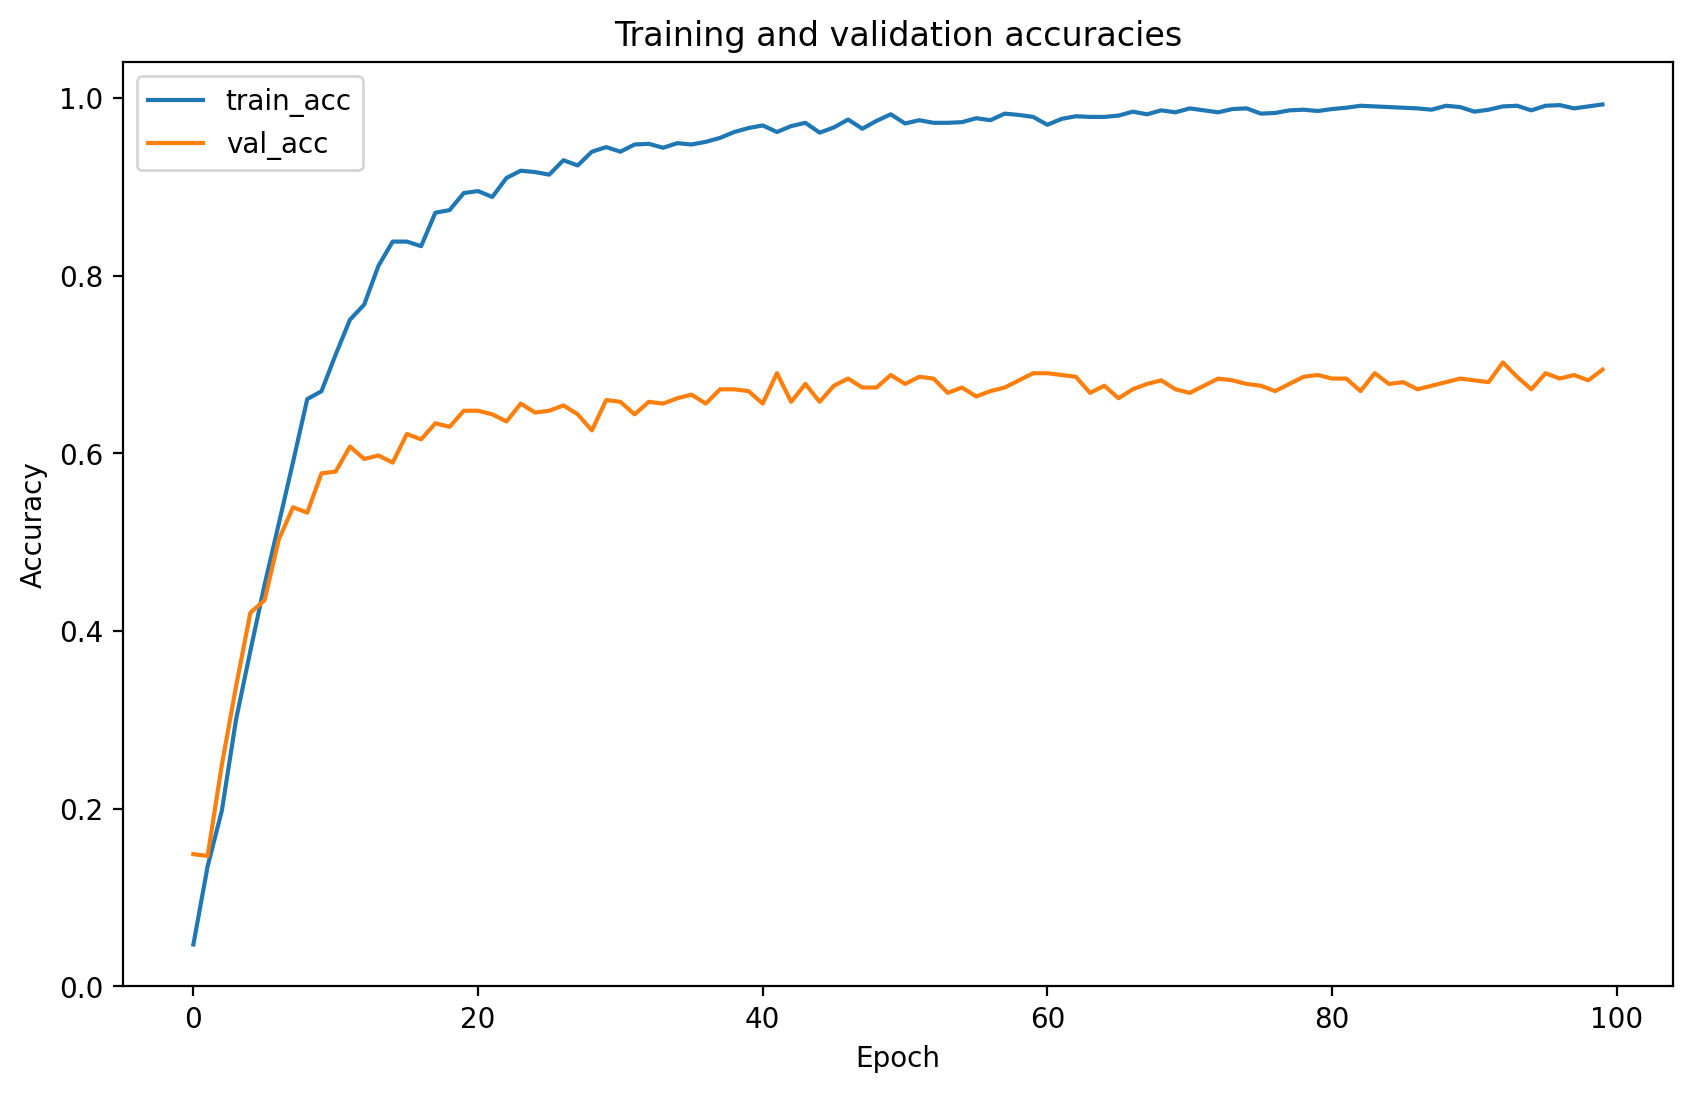

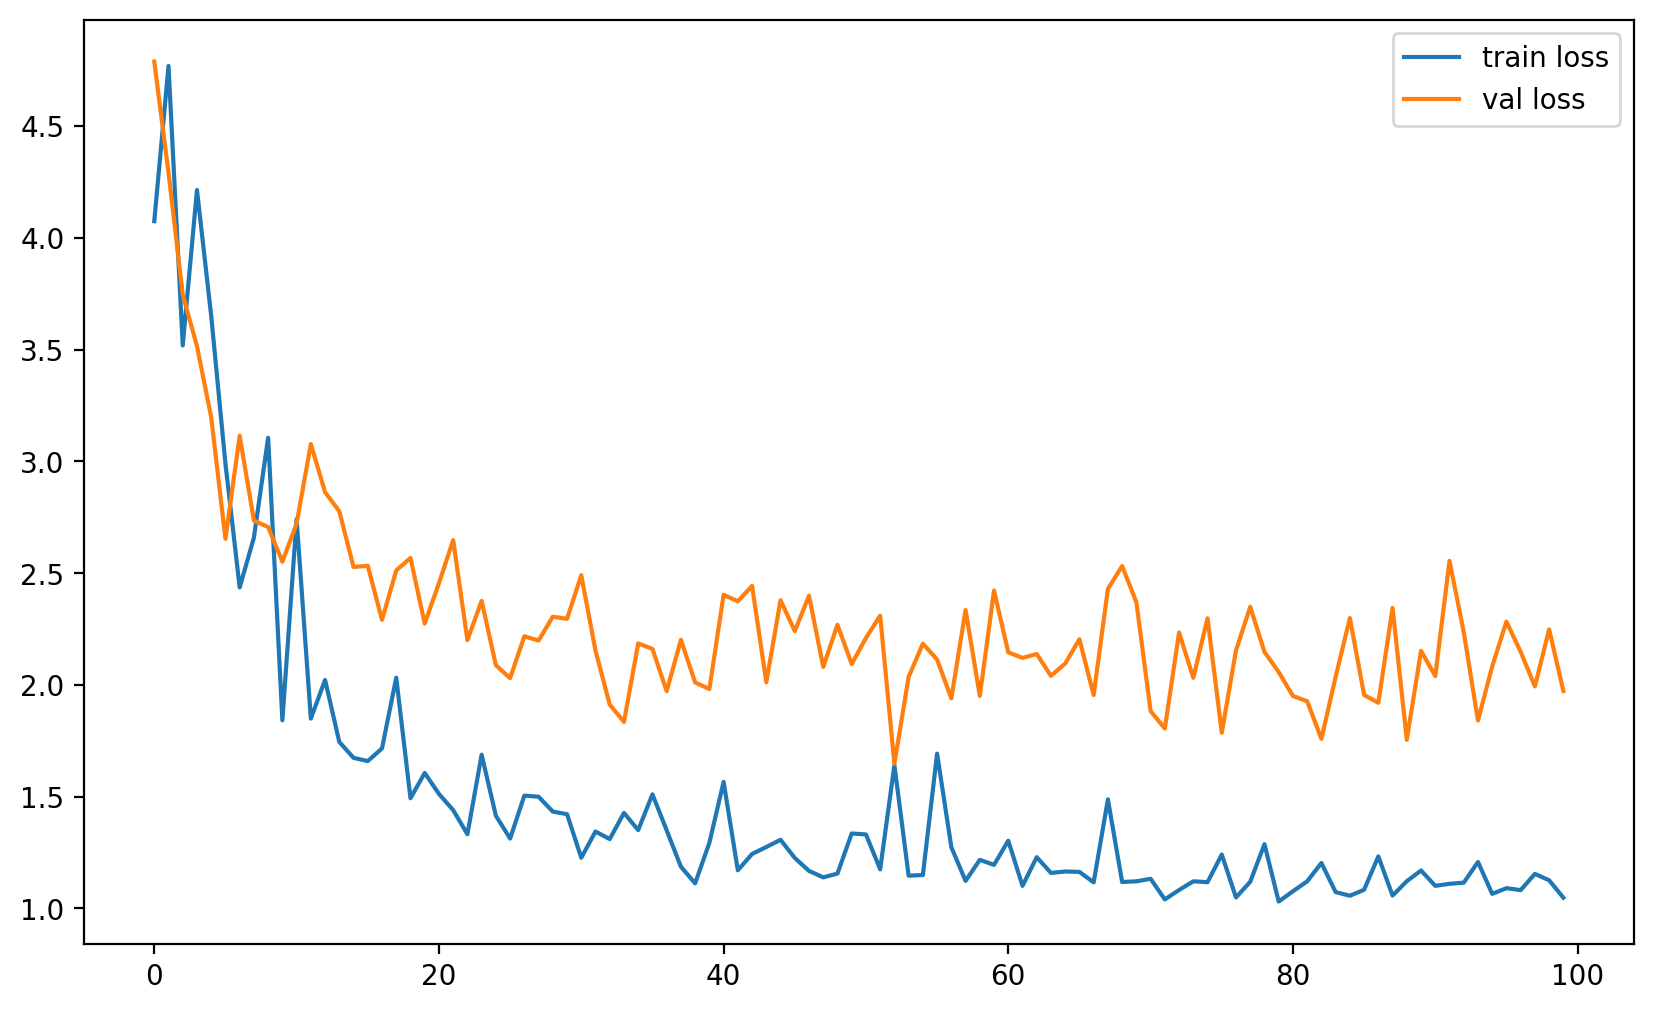

In [138]:
model_ft = train_model(model, criterion, optimizer, exp_lr_scheduler, num_epochs = 100) # now it is a lot faster

In [140]:
test_loss = 0.0
class_correct = list(0 for i in range(len(classes)))
class_total = list(0 for i in range(len(classes)))
model_ft.eval()
for data, target in tqdm(test_loader):
    data, target = data.to(device), target.to(device)
    with torch.no_grad(): # turn off autograd for faster testing
        output = model_ft(data)
        loss = criterion(output, target)
    test_loss = loss.item() * data.size(0)
    _, pred = torch.max(output, 1)
    correct_tensor = pred.eq(target.data.view_as(pred))
    correct = np.squeeze(correct_tensor.cpu().numpy())
    if len(target) == 64:
        for i in range(64):
            label = target.data[i]
            class_correct[label] += correct[i].item()
            class_total[label] += 1

test_loss = test_loss / len(test_image_paths)
print('Test Loss: {:.4f}'.format(test_loss))
# print(class_correct)
# print(class_total)
for i in range(len(classes)):
     if class_total[i] > 0:
         print("Test Accuracy of %5s: %2d%% (%2d/%2d)" % (classes[i], 100*class_correct[i]/class_total[i], np.sum(class_correct[i]), np.sum(class_total[i])))
     else:
         print("Test accuracy of %5s: NA" % (classes[i]))
print("Test Accuracy of %0.2f%% (%2d/%2d)" % (100*np.sum(class_correct)/np.sum(class_total), np.sum(class_correct), np.sum(class_total)))

100%|██████████| 11/11 [01:02<00:00,  5.69s/it]

Test Loss: 0.0488
Test Accuracy of Lepidium draba: 50% ( 1/ 2)
Test Accuracy of Galium verum: 100% ( 2/ 2)
Test Accuracy of Salvia limbata: 100% ( 1/ 1)
Test Accuracy of Astragalus oocephalus: 50% ( 1/ 2)
Test Accuracy of Ononis spinosa: 50% ( 1/ 2)
Test Accuracy of Papaver dubium: 50% ( 1/ 2)
Test Accuracy of Cerastium armeniacum: 100% ( 1/ 1)
Test Accuracy of Potentilla sp: 100% ( 6/ 6)
Test Accuracy of Verbascum armenum: 100% ( 2/ 2)
Test Accuracy of Helichrysum sp: 100% ( 7/ 7)
Test Accuracy of Onopordum acanthium: 50% ( 1/ 2)
Test Accuracy of Hedysarum sp: 100% ( 5/ 5)
Test Accuracy of Cotoneaster nummularius: 50% ( 1/ 2)
Test Accuracy of Quercus petraea: 50% ( 1/ 2)
Test Accuracy of Artemisia sp: 100% ( 8/ 8)
Test Accuracy of Ferula orientalis: 100% ( 1/ 1)
Test Accuracy of Achillea vermicularis: 100% ( 2/ 2)
Test Accuracy of Lotus gebelia: 100% ( 2/ 2)
Test Accuracy of Onopordum sp: 100% ( 4/ 4)
Test Accuracy of Centaurea virgata: 50% ( 1/ 2)
Test Accuracy of Carduus nutans: 50%